# Part III: Generate KDEs and obtain persistence diagrams

- Compute the four cardinal directional distance transforms (distance to the closest cell wall along a given cardinal direction) for the cross section.
- Compute a KDE with a grid of stepsize `stepsize`
- Correct KDE boundaries: treat cell walls and nuclei as steep walls.
- Compute sub or superlevel persistence

Notice that the KDE itself is not saved, as it can easily computed again if necessary.
- Saving it would be quite expensive in the long run

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os
from scipy import ndimage, interpolate, spatial, stats

from KDEpy import FFTKDE
import gudhi as gd
import json

import utils
from importlib import reload

# Load all general data

- Same setup as in the previous notebooks

In [3]:
pows2 = 2**np.arange(20) + 1
fs = 15
bw = 10
PP = 6
stepsize = 3
pp = 0

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
sample = 'D2'

dst = '../suplevel/'
figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'

ksrc += sample + os.sep
dst += sample + os.sep
if not os.path.isdir(dst):
    os.mkdir(dst)

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))

wall[tf.imread(nsrc + sample + '_EDT.tif') < 2] = False
print('Detected',cellnum,'cells')

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

transcriptomes = list(metatrans['gene'])
translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)

for i in range(len(transcriptomes)):
    tdst = dst + transcriptomes[i]
    if not os.path.isdir(tdst):
        os.mkdir(tdst)

Detected 2937 cells


# Compute transcript weights for KDE

- If transcript is close to a border (cell wall or nucleus), it becomes heavier to then reflect the Gaussian "weight"
- Inspired from this thread in [crossvalidated](https://stats.stackexchange.com/questions/65866/good-methods-for-density-plots-of-non-negative-variables-in-r/).
- In this case, the weight variability is restrained: it will be at most `2`
- An unaffected transcript will have weight `1` instead.

In [4]:
filename = ksrc + sample + '_border_weights.npy'

if not os.path.isfile(filename):
    top, right, bottom, left = cardinal_distance_transform(wall)
    wv = stats.norm.cdf(top[tlocs['Y'].values, tlocs['X'].values]+pp, loc=0, scale=bw)
    wv-= stats.norm.cdf(-bottom[tlocs['Y'].values, tlocs['X'].values]-pp, loc=0, scale=bw)
    
    wh = stats.norm.cdf(right[tlocs['Y'].values, tlocs['X'].values]+pp, loc=0, scale=bw) 
    wh-= stats.norm.cdf(-left[tlocs['Y'].values, tlocs['X'].values]-pp, loc=0, scale=bw)
    
    weight = 2-(wv*wh)
    np.save(filename, weight)

weight = np.load(filename, allow_pickle=True)

![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/main/mcarto/figs/D2_GLYMA_05G092200_1749_1748_distance_transform.jpg)

# Select a cell and then a gene

- Get a nice bounding box to just focus on a given cell `cidx`
- A tri-color image `cell` is produced, where
    - `0` is for nuclei and walls
    - `1` for other cytoplasm
    - `2` for the cytosol of the specified cell 
- Produce a regular grid for that box of stepsize `stepsize`
- The grid extends beyond the box by a factor `pad` to account for numerical overflows when the computing KDE
- Get the transcripts of the gene inside that cell

In [10]:
cidx = 10

ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wall.shape[0], metacell.loc[cidx, 'y1'] + PP])],
      np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wall.shape[1], metacell.loc[cidx, 'x1'] + PP])])
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)
cell = wall[ss].copy().astype(np.uint8)
cell[ label[ss] == cidx+1 ] = 2
cell[~wall[ss]] = 0

maxdims = ( cell.shape[1], cell.shape[0], np.max(tlocs['Z']+stepsize) )
print('Maxdims:\t',maxdims)
axes, grid, gmask = utils.kde_grid_generator(stepsize=stepsize, maxdims=maxdims, pows2 = pows2, pad=1.5)
grid[:, :2] = grid[:, :2] + np.array([ss[1].start, ss[0].start])

tidx = 26

tdst = dst + transcriptomes[tidx] + os.sep
coords = translocs[tidx].values.T
kdst = dst + transcriptomes[tidx] + os.sep
print(transcriptomes[tidx], metatrans.iloc[tidx]['cyto_number'], kdst, sep='\t')

cmask = label[ coords[1], coords[0] ] == cidx + 1
ccoords = coords[:, cmask ].copy()
print(cidx, ccoords.shape, sep='\t')

Maxdims:	 (430, 660, 64)
GLYMA_05G092200	764844	../suplevel/D2/GLYMA_05G092200/
10	(3, 225)


# Compute, crop, and correct the KDE

- For comparison we compute an unweighted KDE `uwkde`
- This KDE is then cropped and reweighted to remove the grid padding
- In reality, we want a weighted KDE `kde`, with weights as mentioned above
- It is also cropped and reweighted to remove grid padding
- But then we also remove anything outside the specified cytosol and reweigh again

![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/main/mcarto/figs/D2_GLYMA_05G092200_1749_1748_3D_kde_correction.gif)

In [13]:
uwkde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(ccoords.T).evaluate(grid)
uwkde = uwkde[gmask]/(np.sum(uwkde[gmask])*(stepsize**len(coords)))
uwkde = uwkde.reshape( list(map(len, axes))[::-1], order='F')
print(np.sum(uwkde)*(stepsize**len(coords)))
maxuwkde = np.max(uwkde)

1.0000000000000004


In [14]:
w = weight[tcumsum[tidx]:tcumsum[tidx+1]][cmask]
wmax = np.max(w)

kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(ccoords.T, w).evaluate(grid)
kde = kde[gmask]/(np.sum(kde[gmask])*(stepsize**len(coords)))

cgrid = grid[gmask].copy()
cgrid[:,:2] = grid[gmask][:,:2] - np.array([ss[1].start, ss[0].start])
kde[ cell[cgrid[:,1],cgrid[:,0]] != 2 ] = 0
kde = kde/(np.sum(kde)*(stepsize**len(coords)))
kde = kde.reshape( list(map(len, axes))[::-1], order='F')
print(np.sum(kde)*(stepsize**len(coords)))
maxkde = np.max(kde)

diff = kde - uwkde
maxd = np.max(np.abs(diff))/2
vmax = max([maxkde, maxuwkde])

1.0000000000000002


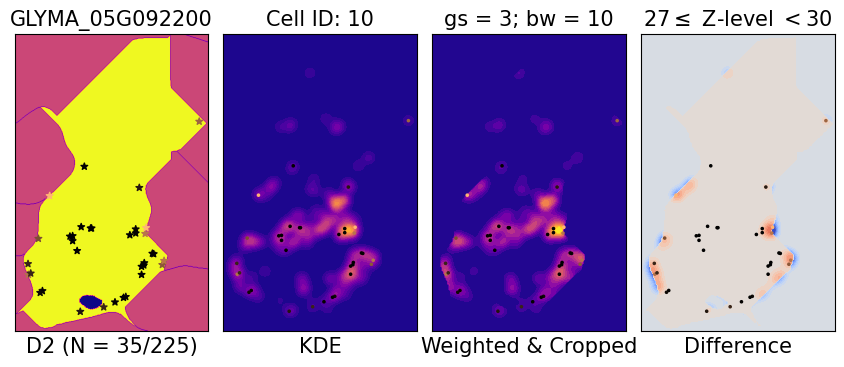

In [16]:
zlevel = len(axes[2])//2-2
fig, ax = plt.subplots(1,4,figsize=(8.5,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax); j = 0

zmask = (ccoords[2] >= axes[2][zlevel]) & (ccoords[2] < axes[2][zlevel+1])
ax[j].imshow(cell, cmap='plasma', origin='lower', extent=extent); j+=1
for density in [uwkde,kde]:
    ax[j].contourf(axes[0]+ss[1].start, axes[1]+ss[0].start, density[zlevel,:,:], 16, cmap='plasma', vmin=0, vmax=vmax, zorder=1)
    j += 1
ax[j].contourf(axes[0]+ ss[1].start, axes[1]+ss[0].start, diff[zlevel,:,:], 32, cmap='coolwarm', vmin=-maxd, vmax=maxd)

if np.sum(zmask) > 0:
    ax[0].scatter(ccoords[0][zmask], ccoords[1][zmask], c=w[zmask], cmap='copper', marker='*', 
                  zorder=3, s=25, alpha=1, vmin=1, vmax=wmax);
    for i in range(1,len(ax)):
        ax[i].scatter(ccoords[0][zmask], ccoords[1][zmask], c=w[zmask],
                      cmap='copper', marker='o', s=2.5, alpha=1, zorder=3, vmin=1, vmax=wmax)

xlabs = ['{} (N = {}/{})'.format(sample, np.sum(zmask), len(ccoords[0])), 'KDE', 'Weighted & Cropped', 'Difference']
titles = [transcriptomes[tidx], 'Cell ID: {}'.format(metacell.loc[cidx, 'orig_cellID']), 'gs = {}; bw = {}'.format(stepsize, bw),
          '${}\leq$ Z-level $< {}$'.format(*axes[2][zlevel:zlevel+2])]

for i in range(len(xlabs)):
    ax[i].set_title(titles[i], fontsize=fs)
    ax[i].set_xlabel(xlabs[i], fontsize=fs)
    ax[i].set_aspect('equal')
    ax[i].margins(0)
    ax[i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

fig.tight_layout();

#filename = '{}{}_{}_{}_{}_3D_kde_correction_z{:02d}'.format(figdst,sample,transcriptomes[tidx],metacell.loc[cidx,'orig_cellID'],cidx,zlevel)
#plt.savefig(filename + '.png', format='png', dpi=96, bbox_inches='tight', transparent=True)

# Cubical persistence

In [20]:
def get_level_filtration(arr, level):
    if level

NameError: name 'level' is not defined

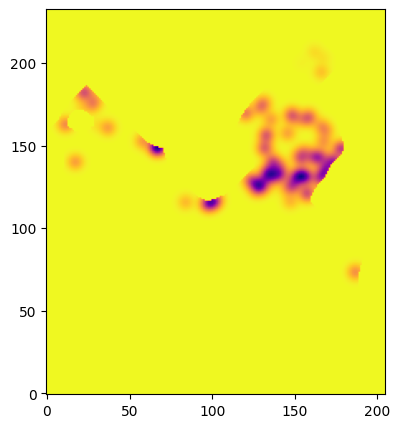

In [19]:
fig, ax = plt.subplots(1,1,figsize=(5,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(kde[zlevel,:,:], origin='lower', cmap='plasma', vmin=0, zorder=1);

In [15]:
print(np.min(kde), np.max(kde), kde.shape, len(metacell))

0.0 9.519646234636512e-06 (22, 233, 205) 2937


In [16]:
cc = gd.CubicalComplex(top_dimensional_cells = kde)
pers = cc.persistence(homology_coeff_field=2, min_persistence=1e-15)
print(len(pers))
pers

20


[(2, (5.307101003142905e-07, 9.519646234636512e-06)),
 (2, (5.769972913152482e-08, 6.427544701827364e-06)),
 (2, (3.277271560828956e-07, 5.838221083010622e-06)),
 (2, (2.6152081269873215e-07, 5.586022380917344e-06)),
 (2, (7.471012383292991e-07, 5.585142327116504e-06)),
 (2, (8.650032942548589e-07, 5.679541870524144e-06)),
 (2, (1.301823910523224e-06, 5.592176101011694e-06)),
 (2, (1.9511384382150084e-06, 5.700671408534926e-06)),
 (2, (2.7954193230867233e-06, 5.694752038466497e-06)),
 (1, (0.0, 2.857156064469745e-07)),
 (1, (2.276331864416171e-16, 2.617758175969482e-07)),
 (1, (1.3190860398767321e-08, 2.0476972477902738e-07)),
 (1, (2.4369023854749747e-08, 1.5981107399731308e-07)),
 (1, (4.4713584301811635e-08, 1.483737627581576e-07)),
 (1, (4.02538424041248e-09, 9.834046182297927e-08)),
 (1, (5.646591215611795e-07, 6.480244283582793e-07)),
 (1, (1.641170857504257e-06, 1.6859899636569843e-06)),
 (1, (2.276331563463606e-16, 4.2932983745469345e-08)),
 (1, (3.749841041848543e-08, 6.296815

In [21]:
with open(filename, 'w') as f:
    json.dump(pers,f)

../sublevel/D2/GLYMA_05G023700_-_sub_p6_s3_bw10_c000001.json


In [30]:
bd = np.zeros((len(pers), 3), dtype=float)
for i in range(len(bd)):
    bd[i, 0] = pers[i][0]
    bd[i, 1:] = pers[i][1]
bd[ bd == np.inf] = vmax

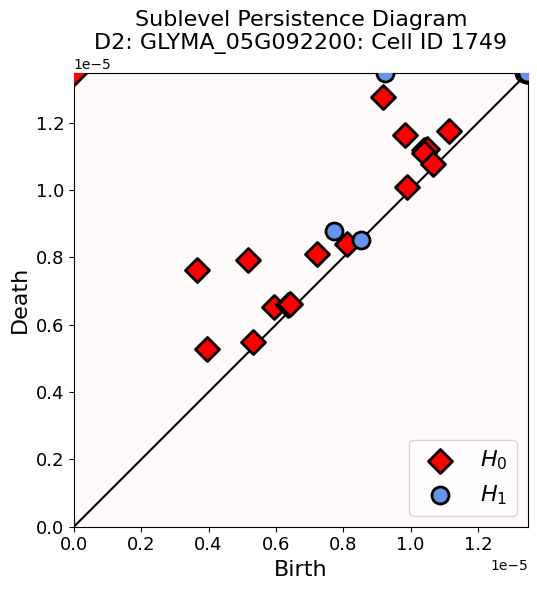

In [32]:
fs = 16; marker = ['D', 'o']; color = ['red','cornflowerblue']
fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(2):
    mask = bd[:,0] == i
    ax[0].scatter(bd[mask, 1], bd[mask, 2], label='$H_{}$'.format(i), marker=marker[i], 
                  c=color[i], s=150, linewidth=2, edgecolor='k', zorder=i+4)

ax[0].scatter([0, np.max(bd[:,1:])] , [np.max(bd[:,1:]), np.max(bd[:,1:])] , alpha=0)
ax[0].legend(loc='lower right', fontsize=fs)
ax[0].set_aspect(1)
ax[0].axline(xy1=(0,0), slope=1, c='k', zorder=1)
ax[0].tick_params(labelsize=fs-3)
ax[0].set_xlabel('Birth', fontsize=fs)
ax[0].set_ylabel('Death', fontsize=fs)
ax[0].margins(0)
ax[0].set_facecolor('snow')

title = 'Sublevel Persistence Diagram\n{}: {}: Cell ID {}'.format(sample, transcriptomes[tidx], metacell.loc[cidx, 'orig_cellID'])
ax[0].set_title(title, fontsize=fs)

fig.tight_layout()